# Notebook de testing

In [1]:
# Librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
from scipy.stats import ttest_ind, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

# sube de notebooks/ a la raíz del repo

sys.path.append(str(Path.cwd().parent))

import src.functions as fc

%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [ ]:
df1 = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_demo.txt")
df2 = fc.load_data_merge("20260217_1045_df2_merged.csv")
df3 = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/lessons/refs/heads/main/5_6_eda_inf_stats_tableau/project/files_for_project/df_final_experiment_clients.txt")

In [3]:
df2.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


In [4]:
# Drop

df3 = df3.dropna()

## Tasa de finalización por grupo

In [5]:
# Filtro por grupo

test = df3[df3["Variation"]=="Test"]
control = df3[df3["Variation"]=="Control"]

control

,client_id,Variation
2,4033851,Control
4,9294070,Control
7,6651403,Control
9,2105948,Control
12,9814849,Control
...,...,...
50491,4364429,Control
50493,8730282,Control
50494,5305116,Control
50495,393005,Control


In [6]:
# Filtramos grupo de control

df_control = df2[df2["client_id"].isin(control["client_id"])]
df_test = df2[df2["client_id"].isin(test["client_id"])]

# Tasa de finalizacion por grupo

tasa_finalizacion_control = fc.tasa_finalizacion(df_control)
tasa_finalizacion_test = fc.tasa_finalizacion(df_test)

tasa_finalizacion_control, tasa_finalizacion_test

(65.59, 69.29)

## TEST 1

In [7]:
# H0 -> tasa de finalización Test = control
# H1 -> tasa de finalización Test != control

finish_control = fc.finish(df_control)

finish_test = fc.finish(df_test)

_, p_value = ttest_ind(finish_control, finish_test, equal_var=False)

p_value

np.float64(8.009768670783661e-19)

- Rechazamos la hipótesis nula y aceptamos la hipótesis alternativa con un nivel de significancia del 5%

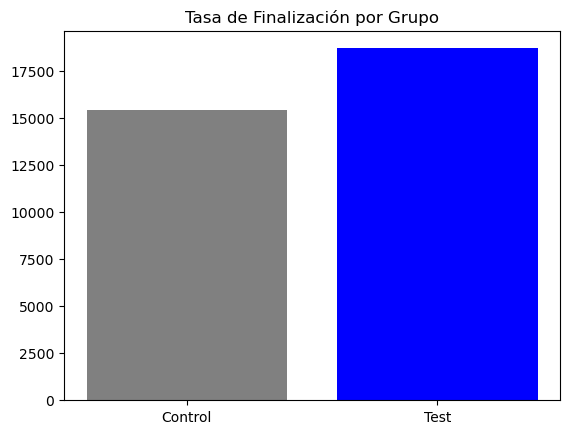

In [8]:
labels = ['Control', 'Test']
valores = [finish_control.sum(), finish_test.sum()]

plt.bar(labels, valores, color=['gray', 'blue'])
plt.title('Tasa de Finalización por Grupo')
plt.show()

In [9]:
# tasa de crecimiento relativo = nuevo - antiguo / antiguo

tasa_crecimiento_relativo = (tasa_finalizacion_test - tasa_finalizacion_control) / tasa_finalizacion_control * 100

tasa_crecimiento_relativo

5.64110382680287

- Sí se puede aplicar dado que ha crecido más de un 5%. Ha superado el umbral marcado por la empresa: es rentable.

## TEST 2. Testing por usuario hasta confirm (control vs test)

In [10]:
# Constantes e hipótesis

ALPHA = 0.05
CONFIRM_STEP = "confirm"
ALT = "less"

# H0: test no es más rapido (igual o peor)
# H1: test es más rápido

In [11]:
# 1) Preparar datos de eventos (tipos y orden)

df_events = df2.copy()

df_events = fc.to_datetime(df_events)

control_times, test_times, df_times = fc.calcular_tiempo_para_test(df_events, df3)


In [12]:
# 2) TEST

_, p_value_times = ttest_ind(test_times, control_times, alternative="less", equal_var=False)

p_value_times

# Hay evidencia estadística a favor de H1. Se rechaza hipótesis
# nula y se acepta alternativa. 

np.float64(1.324369909605251e-05)

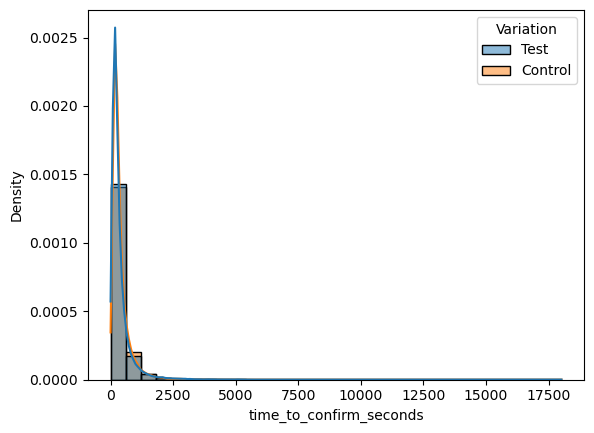

In [13]:
sns.histplot(df_times, x="time_to_confirm_seconds", hue="Variation", kde=True,
             stat="density", common_norm=False, bins=30)
plt.show()


## TEST 3. Por edad promedio (Test vs Control)

In [14]:
#H0 -> edad promedio Test = edad promedio Control 

#H1 -> edad promedio Test != edad promedio Control 

In [15]:
test_edad, control_edad, df_demo_ab = fc.preparar_grupos_experimento(df1, df3, "clnt_age")
_, p_value_age = ttest_ind(test_edad.dropna(), control_edad.dropna(), equal_var=False)

print(p_value_age)


0.015692719461388685


Rechazamos la hipótesis nula y aceptamos la hipótesis alternativa con un nivel de significancia del 5%.

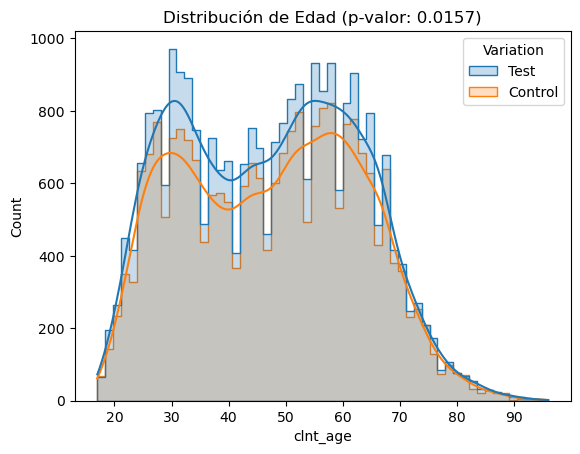

In [16]:
sns.histplot(data=df_demo_ab, x="clnt_age", hue="Variation", kde=True, element="step")
plt.title(f"Distribución de Edad (p-valor: {p_value_age:.4f})")
plt.show()

Comprobamos que las curvas de ambos grupos siguen la misma forma. Pero destacamos que el grupo Test tiene más usuarios encuestados que el grupo Control.

## TEST 4. Por permanencia promedio (Test vs Control)

In [17]:
#H0 -> permanencia promedio Test = permanencia promedio Control

#H1 -> permanencia promedio Test != permanencia promedio Control

In [18]:
test_permanencia, control_permanencia, _ = fc.preparar_grupos_experimento(df1, df3, "clnt_tenure_yr")

In [19]:
_, p_value_permanencia = ttest_ind(test_permanencia.dropna(), control_permanencia.dropna(), equal_var=False)

print(p_value_permanencia)

0.08699034968593344


No podemos rechazar la hipótesis nula, por lo que no hay evidencia de una diferencia en la permanencia.

/var/folders/p5/k72mxyjd6fq22gzlrpbtzhz40000gn/T/ipykernel_30691/4166203630.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_demo_ab, x="Variation", y="clnt_tenure_yr", palette="Set2")


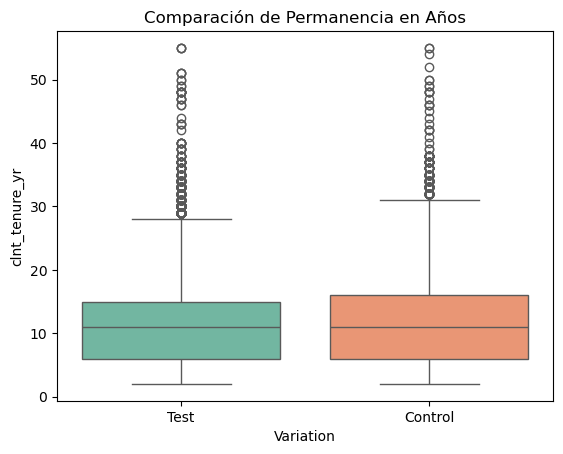

In [20]:
sns.boxplot(data=df_demo_ab, x="Variation", y="clnt_tenure_yr", palette="Set2")
plt.title("Comparación de Permanencia en Años")
plt.show()

Aunque el grupo Control tiene una mediana de permanencia ligeramente superior, no hay una diferencia significativa. Esto demuestra que los grupos están equilibrados y que la permanencia del usuario no sesgará los resultados del experimento.

## EXPORTACIÓN PARA TABLEAU

In [21]:
# Exportacion para Tableau (3 datasets)

# 1) Tiempo hasta confirm por usuario (1 fila por client_id)
fc.save_data_clean_excel(df_times, "df_times")

# 2) Demografia + asignacion al experimento (df1 + df3)
fc.save_data_clean_excel(df_demo_ab, "df_demo_ab")

# 3) Eventos enriquecidos con Variation (para funnels/steps)
df_events_ab = df_events.merge(
    df3[["client_id", "Variation"]].drop_duplicates(),
    on="client_id",
    how="inner",
)
fc.save_data_clean_excel(df_events_ab, "df_events_ab")



Guardado: /Users/jbp/Desktop/IRONHACK/project2-cx-julio-juanjo/data/cleaned/20260217_1046_df_times.xlsx
Guardado: /Users/jbp/Desktop/IRONHACK/project2-cx-julio-juanjo/data/cleaned/20260217_1046_df_demo_ab.xlsx
Guardado: /Users/jbp/Desktop/IRONHACK/project2-cx-julio-juanjo/data/cleaned/20260217_1046_df_events_ab.xlsx


'ok'